## Environment

In [1]:
import os
import gc
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.utils.data as data_utils

from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from utils.utils import *

In [2]:
seed = 42

# Seed fixed : for reproducibility
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)  
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    np.random.seed(seed)

seed_everything(seed) 

In [3]:
!nvidia-smi -L

device = get_default_device()

GPU 0: NVIDIA GeForce RTX 4090 (UUID: GPU-480b86ce-82c7-48b7-a7dd-fc17ae650136)


## EDA - Data Pre-Processing

### Download dataset

In [4]:
# #normal period
# !python utils.gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw data/SWaT

# #anomalies
# !python utils.gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 data/SWaT

### Normal period

In [5]:
# Read data
normal = pd.read_csv("data/SWaT/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

/tmp/ipykernel_623/2933639196.py:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  normal = pd.read_csv("data/SWaT/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)


(495000, 51)

In [6]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

#### Normalization

In [7]:
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)
normal.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,0.005294,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,0.0,0.005407,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
2,0.0,0.005520,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
3,0.0,0.005801,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
4,0.0,0.005576,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


### Attack

In [8]:
# Read data
attack = pd.read_csv("data/SWaT/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

/tmp/ipykernel_623/257133182.py:2: DtypeWarning: Columns (1,9,28,46) have mixed types. Specify dtype option on import or set low_memory=False.
  attack = pd.read_csv("data/SWaT/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)


(449919, 51)

In [9]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

#### Normalization

In [10]:
x = attack.values
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)
attack.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.884144,0.577133,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944116,0.000073,0.0,0.0,0.0
1,0.891145,0.577190,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944521,0.000073,0.0,0.0,0.0
2,0.906779,0.577133,1.0,1.0,0.0,0.496158,0.186209,0.064088,0.981663,1.0,...,0.973530,1.0,0.0,0.946188,0.449782,0.944521,0.000073,0.0,0.0,0.0
3,0.923230,0.577302,1.0,1.0,0.0,0.496158,0.186209,0.064088,0.981663,1.0,...,0.973530,1.0,0.0,0.946188,0.449782,0.944197,0.000073,0.0,0.0,0.0
4,0.935947,0.578034,1.0,1.0,0.0,0.496158,0.186209,0.064088,0.981972,1.0,...,0.973530,1.0,0.0,0.946188,0.449782,0.943629,0.000073,0.0,0.0,0.0


### Windows

In [11]:
window_size=12

In [12]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(494988, 12, 51)

In [13]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(449907, 12, 51)

## Training

In [14]:
w_size=windows_normal.shape[1]*windows_normal.shape[2]

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]

X_train = torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
X_test = torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))

# Isolation Forest model
IF = IsolationForest(contamination=0.1198, random_state=seed)  # anomaly ratio set

# Model fitting
IF.fit(X_train)

IsolationForest(contamination=0.1198, random_state=42)

In [15]:
# Memory clear with garbage collector
del normal
del windows_normal
del windows_normal_train
del X_train

gc.collect()

24

## Testing

In [17]:
# Anomaly scores calc
scores = IF.decision_function(X_test)
scores = (scores - np.min(scores) + 1e-8) / (np.max(scores) - np.min(scores) + 2 * 1e-8)
scores = (2 - 1e-8) * (scores - ((np.max(scores) - np.min(scores)) / 2))

In [18]:
# Anomaly labels processing
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))
    
labels = np.array([-1 if (np.sum(window) > 0) else 1 for window in windows_labels ])

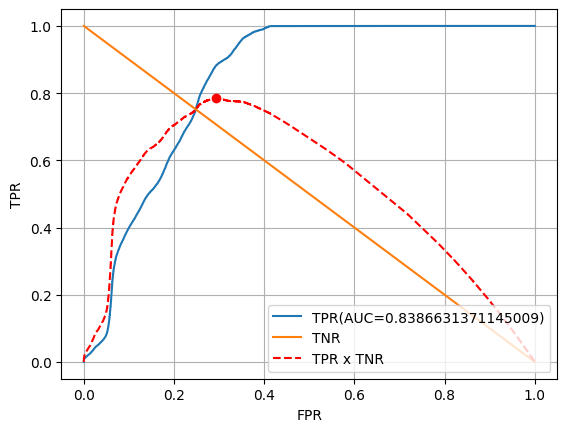

0.016456217769524644


In [19]:
# Thresholding
threshold=ROC(labels,scores)
print(threshold)

In [20]:
def calc_metrics(scores, labels, pos, best_threshold=None):
    best_precision = 0
    best_recall = 0
    best_f1_score = 0

    if best_threshold == None:
        for threshold in np.linspace(np.min(scores), np.max(scores), num=100):
            predictions = np.where(scores > threshold, 1, -1)
            
            F1_Score = f1_score(labels, predictions, pos_label=pos)
            if F1_Score > best_f1_score:
                best_precision= precision_score(labels, predictions, pos_label=pos)
                best_recall = recall_score(labels, predictions, pos_label=pos)
                best_f1_score = F1_Score

                best_threshold = threshold
    else:
        predictions = np.where(scores > best_threshold, 1, -1)
        
        best_precision = precision_score(labels, predictions, pos_label=pos)
        best_recall = recall_score(labels, predictions, pos_label=pos)
        best_f1_score = f1_score(labels, predictions, pos_label=pos)        
    
    print("dectection precision: ", best_precision)
    print("dectection recall:    ", best_recall)
    print("dectection f1 score:  ", best_f1_score)
    print("\ndectection threshold:", best_threshold)
    
    return best_threshold

In [21]:
# Evaluation
print('normal dectection metrics:\n')
threshold = calc_metrics(scores=scores, labels=labels, pos=1, best_threshold=threshold)

normal dectection metrics:

dectection precision:  0.955767255631045
dectection recall:     0.8813221541601566
dectection f1 score:   0.9170363207354524

dectection threshold: 0.016456217769524644


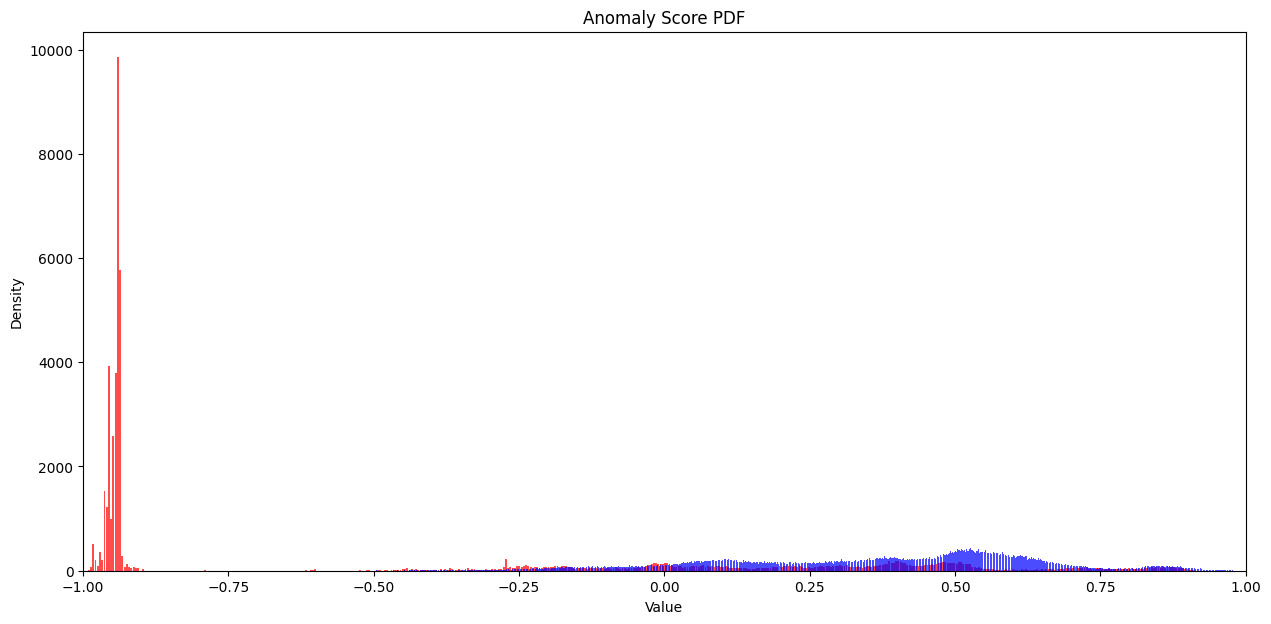

In [22]:
# Distribution
plt.figure(figsize=[15, 7])
plt.hist(scores[np.argwhere(labels == -1)], bins=500, density=False, alpha=0.7, rwidth=0.85, label='anomaly', color='red')
plt.hist(scores[np.argwhere(labels == 1)], bins=int(500 / 0.1198), density=False, alpha=0.7, rwidth=0.85, label='normal', color='blue')
plt.xlabel('Value')
plt.ylabel('Density')
plt.xlim(-1,1)
plt.title('Anomaly Score PDF')
plt.show()